## 1. Импортируем необходимые библиотеки и пакеты

In [1]:
%matplotlib inline
from typing import Union, Tuple
from functools import partial, wraps
import time
import csv
from os import path, getcwd, mkdir, chdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
sns.set()

In [2]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE

## 2. Загрузим датасет, удалим NA-значения и изучим его

In [3]:
df = pd.read_csv('2_5.csv', header=None, sep=';').astype('uint8').dropna()
df.sample(10)

,0,1,2,3,4,5,6,7,8,9
714,30,3,3,7,1,1,3,4,0,3
371,37,2,3,4,1,1,2,3,0,1
468,24,1,4,1,1,0,4,2,1,2
704,22,3,2,2,1,1,2,1,0,3
267,42,3,4,10,1,0,3,2,0,1
691,29,2,4,3,1,1,3,3,0,3
1366,25,4,4,2,1,1,1,2,0,3
1065,36,1,4,1,1,1,3,3,0,1
948,32,3,4,4,1,1,3,2,0,3
1133,28,3,4,0,1,0,3,4,0,1


In [4]:
df[0]=KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='ordinal').fit_transform(df[0].values.reshape(-1,1)).reshape(1,-1).T.astype('uint8')

In [17]:
def timeit(filename: Union[str, None]=None):
    def inner(method: Callable[...,...]):
        @wraps(method)
        def timed(*args, **kwargs):
            ts = time.time()
            result = method(*args, **kwargs)
            te = time.time()
            print('%r execution completed in %d m %2.2f s' % \
                      (method.__name__, (te - ts)//60, ((te-ts)-60*((te - ts)//60)) ))
            if (filename is not None) and (type(result)==dict):
                result.update({'time':'{} m {:2.2f} s'.format((te - ts)//60, ((te-ts)-60*((te - ts)//60)))})
                with open(filename, 'a+', newline='') as f:
                    pd.DataFrame(result, index=['method']).to_csv(f, header=f.tell()==0)
            return result
        return timed
    return inner

In [18]:
@timeit()
def show_heatmap(data: Union[np.ndarray, pd.DataFrame], title: str, figsize: tuple=(10,10)) -> None:
    plt.figure(figsize=figsize)
    plt.title(title,)
    hm = sns.heatmap(data, annot=True)
    plt.show()

In [19]:
@timeit(filename='\\results.csv')
def get_best_estimator(estimator: Pipeline, dataset: dict, params_search: dict, 
                      return_scores: bool=False, **kwargs) -> Pipeline:
    """
    Simple yet helpful function to get best estimator based on f1 score
    """
    name = str(estimator[-1]).split('(')[0]
    print('calulating %r' %name)
    grid = GridSearchCV(estimator=estimator,
                        param_grid=params_search, 
                        cv=None, 
                        n_jobs=-1,
                       scoring=make_scorer(partial(f1_score, average='weighted'))
                       )
    grid.fit(dataset['X_train'], dataset['y_train'])
    if return_scores:
        fraction=kwargs.pop('train_test_fraction')
        results = dict(method=[],
                      feature_selector=[],
                      train_test_fraction=[],
                      precision=[],
                      recall=[],
                      f1_score=[],
                      accuracy=[])
        results['method'] = name
        results['feature_selector'] = str(estimator[2]).split('(')[0] if name not in ['GradientBoostingClassifier', 'MultinomialNB'] else str(estimator[1]).split('(')[0]
        results['train_test_fraction'] = fraction
        results['precision'] = precision_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']), average='weighted')
        results['recall'] = recall_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']), average='weighted')
        results['f1_score'] = f1_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']), average='weighted')
        results['accuracy'] = accuracy_score(dataset['y_test'], 
                                            grid.best_estimator_.predict(dataset['X_test']))
        return results
    return grid.best_estimator_  

### Базовая аналитика. Выведем корреляционную матрицу

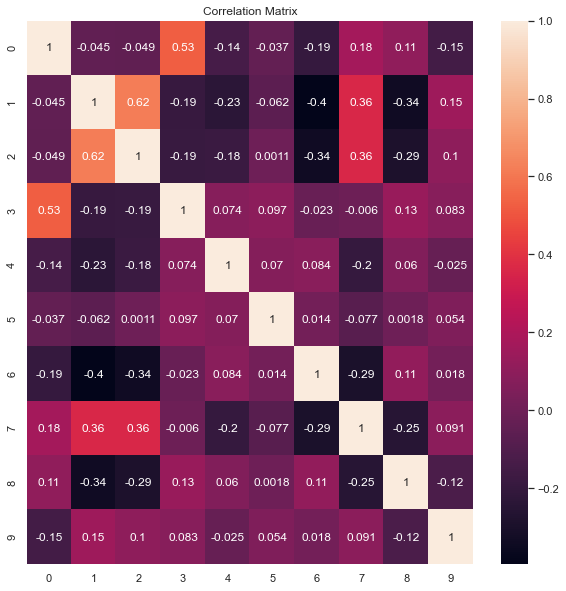

'show_heatmap' execution completed in 0 m 0.75 s


In [8]:
show_heatmap(df.corr(), 'Correlation Matrix')

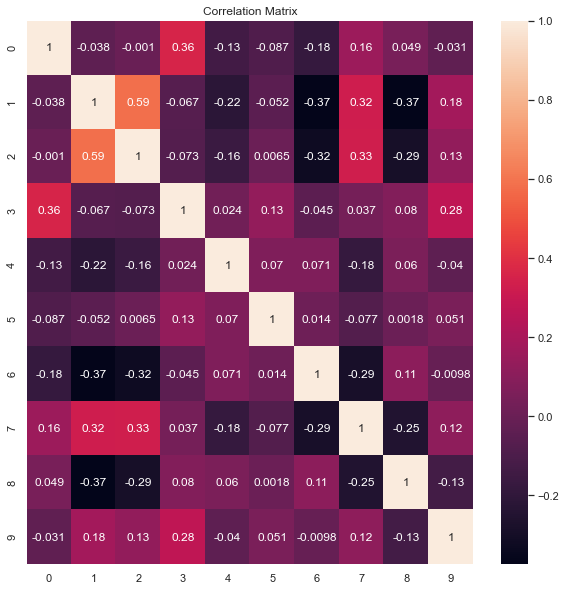

'show_heatmap' execution completed in 0 m 0.73 s


In [9]:
show_heatmap(df.apply(lambda x: np.log(x+0.01)).corr(), 'Correlation Matrix')

### Как видно по последней строке, признаки коррелируют слабо с целевой переменной (переменная под номером 9) 

### Построим пайплайны - модели, где будет выполняться feature engineering и обучение изучаемых моделей 

In [20]:
feature_extractor = {"wrapper_extraction":RFE(estimator=RandomForestClassifier(n_jobs=-1)), 
                    "filter_extraction": SelectKBest(score_func=mutual_info_classif,)}
params_features={'wrapper_extracion':{'rfe__n_features_to_select': range(1,9)},
                 'filter_extraction':{'selectkbest__k': range(1,9)}}

In [21]:
gaussian_pipeline = make_pipeline(FunctionTransformer(lambda x : np.log(x+0.01)),
                                  PolynomialFeatures(degree=2, interaction_only=True),
                                  feature_extractor['filter_extraction'], 
                                  GaussianNB())
bernoulli_pipeline = make_pipeline(
                           FunctionTransformer(lambda x : np.log(x+0.01)),
                           PolynomialFeatures(degree=2, interaction_only=True),
                           feature_extractor['filter_extraction'], 
                           OneHotEncoder(handle_unknown='ignore'), 
                           BernoulliNB())
multinomial_pipeline = make_pipeline(#PolynomialFeatures(degree=2, interaction_only=True),
                             PolynomialFeatures(degree=2, interaction_only=True),
                             feature_extractor['filter_extraction'],
                             MultinomialNB())
grad_boost_pipeline = make_pipeline(PolynomialFeatures(degree=2, interaction_only=True),
                             feature_extractor['filter_extraction'],
                             GradientBoostingClassifier())
svm_nonlinear_pipeline = make_pipeline(FunctionTransformer(lambda x : np.log(x+0.01)),
                             PolynomialFeatures(degree=2, interaction_only=True),
                             feature_extractor['filter_extraction'],
                             StandardScaler(),
                             SVC())

### Разобьем выборку на тренировочную и тестовую

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], train_size=0.6)

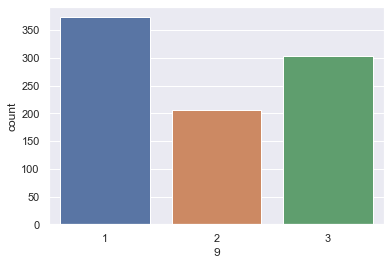

In [23]:
sns.countplot(x=y_train)
plt.show()

### Как видно на графике выше, классы не сбалансированы. Поэтому, дабы увеличить чувствительность модели, проведем оверсэмплинг. 

In [24]:
X_ovr, y_ovr = RandomOverSampler(sampling_strategy='not majority').fit_resample(X_train, y_train,)

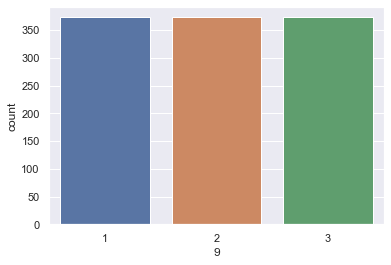

In [25]:
sns.countplot(x=y_ovr)
plt.show()

### Получим наилучшие значения гиперпараметров, обучив модели на сбалансированном датасете с применением кросс-валидации. Целевая метрика - агрегат f1

In [26]:
gaussian_ = get_best_estimator(gaussian_pipeline, 
                               dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                       'X_test':X_test, 'y_test':y_test}, 
                              params_search={**params_features['filter_extraction'],
                                      'gaussiannb__var_smoothing':10**np.linspace(-9,-6,10)},
                              fraction=0.6)
bernoulli_ = get_best_estimator(bernoulli_pipeline, 
                               dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                       'X_test':X_test, 'y_test':y_test}, 
                              params_search={**params_features['filter_extraction'],
                                  'bernoullinb__alpha':np.linspace(1e-10,1,100)},
                               fraction=0.6)
multinomial_ = get_best_estimator(multinomial_pipeline, 
                               dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                       'X_test':X_test, 'y_test':y_test}, 
                              params_search={**params_features['filter_extraction'],
                                  'multinomialnb__alpha':np.linspace(1e-10,1,100)},
                                 fraction=0.6)
grad_boost_ = get_best_estimator(grad_boost_pipeline, 
                               dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                       'X_test':X_test, 'y_test':y_test}, 
                              params_search={**params_features['filter_extraction'],
                                      'gradientboostingclassifier__loss':['deviance', 'exponential'],
                                     'gradientboostingclassifier__learning_rate': 10**np.linspace(-2,-1,20),
                                     'gradientboostingclassifier__n_estimators': 10*np.arange(5,21,3)},
                                fraction=0.6)
svm_nonlinear_ = get_best_estimator(svm_nonlinear_pipeline, 
                               dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                       'X_test':X_test, 'y_test':y_test},
                              params_search={**params_features['filter_extraction'],
                                      'svc__C':np.linspace(1e-2,20,30),
                                     'svc__kernel': ['rbf'],
                                      'svc__coef0': 10**np.linspace(-1,0,10)},
                                   fraction=0.6)

calulating 'GaussianNB'
'get_best_estimator' execution completed in 0 m 30.30 s
calulating 'BernoulliNB'
'get_best_estimator' execution completed in 4 m 36.59 s
calulating 'MultinomialNB'
'get_best_estimator' execution completed in 4 m 32.84 s
calulating 'GradientBoostingClassifier'
'get_best_estimator' execution completed in 16 m 43.77 s
calulating 'SVC'
'get_best_estimator' execution completed in 14 m 38.72 s


In [27]:
results=dict(method=[],
            train_test_fraction=[],
            precision=[],
            recall = [],
            f1_score=[])

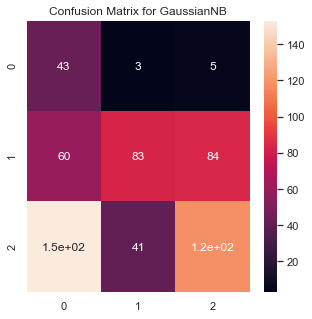

'show_heatmap' execution completed in 0 m 0.19 s
              precision    recall  f1-score   support

           1       0.84      0.17      0.28       256
           2       0.37      0.65      0.47       127
           3       0.38      0.57      0.45       207

    accuracy                           0.41       590
   macro avg       0.53      0.46      0.40       590
weighted avg       0.58      0.41      0.38       590



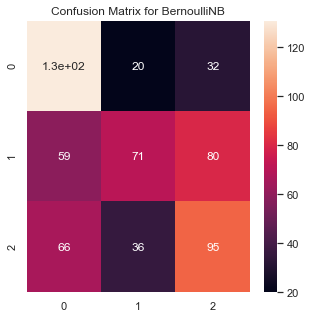

'show_heatmap' execution completed in 0 m 0.20 s
              precision    recall  f1-score   support

           1       0.72      0.51      0.60       256
           2       0.34      0.56      0.42       127
           3       0.48      0.46      0.47       207

    accuracy                           0.50       590
   macro avg       0.51      0.51      0.50       590
weighted avg       0.55      0.50      0.51       590



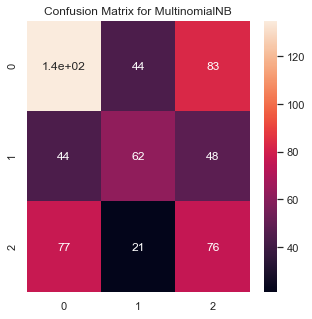

'show_heatmap' execution completed in 0 m 0.17 s
              precision    recall  f1-score   support

           1       0.52      0.53      0.52       256
           2       0.40      0.49      0.44       127
           3       0.44      0.37      0.40       207

    accuracy                           0.46       590
   macro avg       0.45      0.46      0.45       590
weighted avg       0.46      0.46      0.46       590



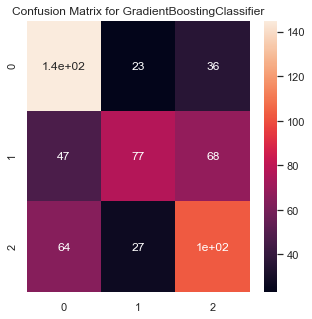

'show_heatmap' execution completed in 0 m 0.16 s
              precision    recall  f1-score   support

           1       0.71      0.57      0.63       256
           2       0.40      0.61      0.48       127
           3       0.53      0.50      0.51       207

    accuracy                           0.55       590
   macro avg       0.55      0.56      0.54       590
weighted avg       0.58      0.55      0.56       590



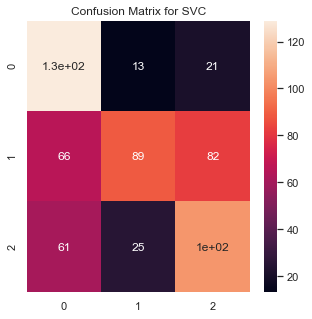

'show_heatmap' execution completed in 0 m 0.16 s
              precision    recall  f1-score   support

           1       0.79      0.50      0.62       256
           2       0.38      0.70      0.49       127
           3       0.55      0.50      0.52       207

    accuracy                           0.55       590
   macro avg       0.57      0.57      0.54       590
weighted avg       0.62      0.55      0.56       590



In [28]:
for estimator in [gaussian_, bernoulli_, multinomial_, grad_boost_, svm_nonlinear_]:
    name = str(estimator[-1]).split('(')[0]
    results['method'].append(name)
    results['train_test_fraction'].append(0.6)
    results['precision'].append(precision_score(y_test, 
                                                  estimator.predict(X_test), average='weighted'))
    results['recall'].append(recall_score(y_test, 
                                                  estimator.predict(X_test), average='weighted'))
    results['f1_score'].append(f1_score(y_test, estimator.predict(X_test), average='weighted'))
    show_heatmap(confusion_matrix(estimator.predict(X_test), y_test),
                 f'Confusion Matrix for {name}', figsize=(5,5))
    print(classification_report(y_test, estimator.predict(X_test)))

In [30]:
pd.DataFrame(results).pivot(index='method', columns=['train_test_fraction'], values=['precision','recall','f1_score'])

,precision,recall,f1_score
train_test_fraction,0.6,0.6,0.6
method,,,
BernoulliNB,0.552572,0.503390,0.514658
GaussianNB,0.577233,0.413559,0.382024
GradientBoostingClassifier,0.581009,0.550847,0.557696
MultinomialNB,0.463478,0.462712,0.461121
SVC,0.616269,0.545763,0.556255


### Как видим - результаты неутешительные, что связанно с слабой коррелиремостью признаков целевой переменной. Вероятнее получить более утешительные результаты, попробоав сгенерировать новые признаки как комбинации имеющихся.

In [32]:
for size in 0.1*np.arange(6,10):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], train_size=size)
    X_ovr, y_ovr = RandomOverSampler(sampling_strategy='all').fit_resample(X_train, y_train)
    for k,v in feature_extractor.items():
        gaussian_pipeline = make_pipeline(FunctionTransformer(lambda x : np.log(x+0.01)),
                                  PolynomialFeatures(degree=2, interaction_only=True),
                                  v, 
                                  GaussianNB())
        bernoulli_pipeline = make_pipeline(
                                   FunctionTransformer(lambda x : np.log(x+0.01)),
                                   PolynomialFeatures(degree=2, interaction_only=True),
                                   v, 
                                   OneHotEncoder(handle_unknown='ignore'), 
                                   BernoulliNB())
        multinomial_pipeline = make_pipeline(#PolynomialFeatures(degree=2, interaction_only=True),
                                     PolynomialFeatures(degree=2, interaction_only=True),
                                     feature_extractor['filter_extraction'],
                                     MultinomialNB())
        grad_boost_pipeline = make_pipeline(PolynomialFeatures(degree=2, interaction_only=True),
                                     v,
                                     GradientBoostingClassifier())
        svm_nonlinear_pipeline = make_pipeline(FunctionTransformer(lambda x : np.log(x+0.01)),
                                     PolynomialFeatures(degree=2, interaction_only=True),
                                     v,
                                     StandardScaler(),
                                     SVC())
        gaussian_ = get_best_estimator(gaussian_pipeline, 
                                       dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                               'X_test':X_test, 'y_test':y_test}, 
                                      params_search={**params_features[k],
                                              'gaussiannb__var_smoothing':10**np.linspace(-9,-6,10)},
                                      train_test_fraction=size,
                                      return_scores=True)
        bernoulli_ = get_best_estimator(bernoulli_pipeline, 
                                       dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                               'X_test':X_test, 'y_test':y_test}, 
                                      params_search={**params_features[k],
                                          'bernoullinb__alpha':np.linspace(1e-10,1,100)},
                                       train_test_fraction=size,
                                       return_scores=True)
        multinomial_ = get_best_estimator(multinomial_pipeline, 
                                       dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                               'X_test':X_test, 'y_test':y_test}, 
                                      params_search={**params_features[k],
                                          'multinomialnb__alpha':np.linspace(1e-10,1,100)},
                                         train_test_fraction=size,
                                         return_scores=True)
        grad_boost_ = get_best_estimator(grad_boost_pipeline, 
                                       dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                               'X_test':X_test, 'y_test':y_test}, 
                                      params_search={**params_features[k],
                                              'gradientboostingclassifier__loss':['deviance', 'exponential'],
                                             'gradientboostingclassifier__learning_rate': 10**np.linspace(-2,-1,20),
                                             'gradientboostingclassifier__n_estimators': 10*np.arange(5,21,3)},
                                        train_test_fraction=size,
                                        return_scores=True)
        svm_nonlinear_ = get_best_estimator(svm_nonlinear_pipeline, 
                                       dataset={'X_train':X_ovr , 'y_train': y_ovr,
                                               'X_test':X_test, 'y_test':y_test},
                                      params_search={**params_features[k],
                                              'svc__C':np.linspace(1e-2,20,30),
                                             'svc__kernel': ['rbf'],
                                              'svc__coef0': 10**np.linspace(-1,0,10)},
                                           train_test_fraction=size,
                                           return_scores=True)

calulating 'GaussianNB'
'get_best_estimator' execution completed in 0 m 31.38 s
calulating 'BernoulliNB'
'get_best_estimator' execution completed in 4 m 53.73 s
calulating 'MultinomialNB'
'get_best_estimator' execution completed in 5 m 6.50 s
calulating 'GradientBoostingClassifier'
'get_best_estimator' execution completed in 18 m 20.70 s
calulating 'SVC'
'get_best_estimator' execution completed in 15 m 27.87 s
calulating 'GaussianNB'
'get_best_estimator' execution completed in 0 m 29.25 s
calulating 'BernoulliNB'
'get_best_estimator' execution completed in 5 m 17.30 s
calulating 'MultinomialNB'
'get_best_estimator' execution completed in 5 m 14.44 s
calulating 'GradientBoostingClassifier'
'get_best_estimator' execution completed in 18 m 55.67 s
calulating 'SVC'
'get_best_estimator' execution completed in 16 m 13.85 s
calulating 'GaussianNB'
'get_best_estimator' execution completed in 0 m 33.03 s
calulating 'BernoulliNB'
'get_best_estimator' execution completed in 5 m 22.26 s
calulating

In [51]:
df = pd.read_csv('\\results.csv').iloc[:,1:]
df.pivot(index=['method','feature_selector'], columns= ['train_test_fraction'], values=['f1_score','accuracy','time'])

f1_score                      \
train_test_fraction                               0.6       0.7       0.8   
method                     feature_selector                                 
BernoulliNB                SelectKBest        0.49293  0.463368   0.53707   
GaussianNB                 SelectKBest       0.397854   0.36055  0.337775   
GradientBoostingClassifier SelectKBest        0.51595  0.476717  0.507751   
MultinomialNB              SelectKBest        0.47458   0.51694  0.459404   
SVC                        SelectKBest       0.497189  0.490877   0.55183   

                                                       accuracy            \
train_test_fraction                               0.9       0.6       0.7   
method                     feature_selector                                 
BernoulliNB                SelectKBest       0.537415  0.489831  0.454751   
GaussianNB                 SelectKBest       0.445459  0.420339   0.38009   
GradientBoostingClassifier SelectKBest       0.648826  0.513559  0.466063   
MultinomialNB              SelectKBest       0.428179  0.474576  0.511312   
SVC                        SelectKBest       0.629695  0.498305  0.488688   

                                                                 \
train_test_fraction                               0.8       0.9   
method                     feature_selector                       
BernoulliNB                SelectKBest       0.532203  0.527027   
GaussianNB                 SelectKBest       0.355932  0.445946   
GradientBoostingClassifier SelectKBest       0.501695  0.641892   
MultinomialNB              SelectKBest       0.481356  0.452703   
SVC                        SelectKBest       0.549153  0.621622   

                                                       time                  \
train_test_fraction                                     0.6             0.7   
method                     feature_selector                                   
BernoulliNB                SelectKBest        4.0 m 53.73 s   5.0 m 22.26 s   
GaussianNB                 SelectKBest        0.0 m 31.38 s   0.0 m 33.03 s   
GradientBoostingClassifier SelectKBest       18.0 m 20.70 s  18.0 m 48.90 s   
MultinomialNB              SelectKBest         5.0 m 6.50 s   5.0 m 18.42 s   
SVC                        SelectKBest       15.0 m 27.87 s  17.0 m 10.16 s   

                                                                             
train_test_fraction                                     0.8             0.9  
method                     feature_selector                                  
BernoulliNB                SelectKBest        5.0 m 46.76 s   6.0 m 34.87 s  
GaussianNB                 SelectKBest        0.0 m 35.77 s   0.0 m 39.15 s  
GradientBoostingClassifier SelectKBest       20.0 m 20.73 s  22.0 m 13.01 s  
MultinomialNB              SelectKBest        5.0 m 43.40 s   6.0 m 31.20 s  
SVC                        SelectKBest        19.0 m 2.98 s  21.0 m 32.50 s

## Выводы: как видим, с лучше всего справляется бустинг, далее идет бернуллиевский наивный байесовский классификатор и (при увеличении доли  обучющих примеров) - метод опорных векторов. Однако, не следует забывать, что при слишком большой доли обучающей выборки модель (достаточно сложная) будет иметь склонность к переобучению, хотя в данной работе использовалась кросс-валидация при подборе гиперпараметров. Наиболее сбалансированные метрики достигаются при доле 0,9. Также на метрику precision повлияло использование балансировки датасета (recall возрос, но при этом precision хуже)